# Lab Deep Learning / Multi-Layer Perceptron for classification / in pytorch

**Author: geoffroy.peeters@telecom-paris.fr**

For any remark or suggestion, please feel free to contact me.

Last edit: 2020/04/27 peeters

Read the "introduction to pytorch" slides first: https://perso.telecom-paristech.fr/gpeeters/doc/pytorch/

**Is is recommended that you first perform the ```Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch``` Lab to understand how to write a Neural Network in pytorch.**


## Objective:

The objective of this lab is to develop a two hidden layers MLP to perform image **classification**.

While the previous Lab ```Lab Deep Learning / Multi-Layer Perceptron for regression / in pytorch``` focused on how to write a Neural Network, the present Lab focuses on managing datasets and splitting training and testing .

We will use MNIST for the image dataset.

## Your task:

You need to add the missing parts in the code (parts between ```# --- START CODE HERE``` and ```# --- END CODE HERE```)

## Documentation:
- NN: https://pytorch.org/docs/stable/nn.html
- Autograd: https://pytorch.org/docs/stable/autograd.html
- Optim: https://pytorch.org/docs/stable/optim.html


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data management

It is common to separate the datasets into
- a **training** part (used to find the network parameters which minimize the loss)
- a **test part** (used to estimate the performances).

The training part can itself be further splitted into a training and a validation part (the validation part is then used to fix the hyper-parameters of the system).

When performing ```batch gradient descent``` the whole training set is used to compute the gradients (which itself is used for the parameter optimization). 
However when performing ```stochastic or mini-batch gradient descent``` only a part of the training data is used at each iteration.

We therefore needs to write all the necessary code, to get these mini-batches of data, be sure that all data have been seen, potentially randomize the order of appearance of these data and potentially perform some modifications of the data before giving them to the network.

Fortunatelly, pytorch has associated to it (but not included in it) a nice package (```torchvision```) which allows to do all that for us.

This package allows to perform these process for any datasets but has a pre-tuned method for the ```MNIST```datasets.

### Datasets

In the following we will us ```datasets.MNIST``` to load the train and test data.

We need to tell it to download the data, where to dowload them and if we want the training or the testing part of it.

We then tell it if we want to apply some transformations to the data.

For this lab, we will transform the data by
- 1) transforming them to torch tensors (using ```transforms.ToTensor()```); since by default they are not torch tensors
- 2) normalize them to zero mean and unit standard deviation (using ```transforms.Normalize()```).

It is of course possible to also apply data augmentation.

Since we have several transforms to be performed, we will compose them using ```transforms.Compose([transform1, transform2])```

The corresponding datasets is a class which contains the pairs of [input tensors $X$, corresponding ground-truth label $y$].

### Dataloader

Another nice pytorch facility is the ```Dataloader``` which transforms the dataset to be used as an iterator (i.e. within ```for data in myDataloader: ```).

Moreover, ```Dataloader``` allows to specify 
- how many data will be provided each time it is called (```batch_size```)
- if the order of appearance of the data with be random (````shuffle````).

We therefore convert our datasets (train and test) to ```DataLoader``` that are directly used as iterator during the iterations (it DataLoader manage directly the mini-batch and shuffling).

In [2]:
# --- START CODE HERE
train_set = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=True)
test_set = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False)
# --- END CODE HERE

In [3]:
print("dataset type: {}".format(type(train_set)))
print("dataset size: {}".format(len(train_set)))
print("X data: {}".format(train_set[0][0].size()))
print("y data: {}".format(train_set[0][1]))

dataset type: <class 'torchvision.datasets.mnist.MNIST'>
dataset size: 60000
X data: torch.Size([1, 28, 28])
y data: 5


### Display the first 5 data of MNIST dataset.

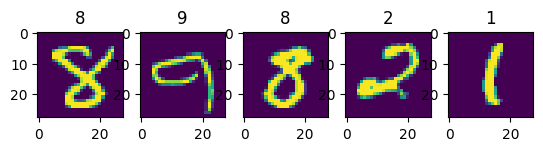

In [4]:
# ------------------------------------
for num in range(0,5):
    one_data = next(iter(train_loader))
    plt.subplot(1,5,num+1)
    plt.imshow(one_data[0][0][0,:,:])
    plt.title(one_data[1][0].item())

## Network setting

While image classification, is usually performed using Convolutional Neural Networks, we will use here a Multi-Layer-Perceptron (also named ```fully-connected```).
For this, we will flatten (i.e. convert the iamge 2D matrix to a 1D vector) the input images.

- The input images are of size 28*28 and are converted to vectors of size ```n_in```=784. 

- The two hidden layers have ````n_h1````=500 and ```n_h2```=256 unit/neurons each and ```Relu``` activations.

- The output are the ```n_out```=10 classes (the 10 digits to be recognized). 

Since we deal with a muti-class problem (10 classes), the output activations is therefore a ```softmax```.

Note that since the ```softmax``` output will be given to a ```cross-entropy```, the ```log``` et the latter can be directly added to the ```softmax```. This leads to the pytorch function ```F.log_softmax```.


In [5]:
class Net(nn.Module):
    def __init__(self):
        n_in = 28*28
        n_h1 = 500
        n_h2 = 256
        n_out = 10
        super(Net, self).__init__()
        # --- START CODE HERE
        self.h1 = torch.nn.Linear(n_in, n_h1)
        self.h2 = torch.nn.Linear(n_h1, n_h2)
        self.predict = torch.nn.Linear(n_h2, n_out)
        # --- END CODE HERE
    def forward(self, x):
        # --- START CODE HERE
        x = F.relu(self.h1(x))
        x = F.relu(self.h2(x))
        x = self.predict(x)
        # --- END CODE HERE
        return F.log_softmax(x, dim=1)

## Defining the train and test functions

In the present lab, we distinguish between train and test data. 
We therefore write
- a train function (to learn the network parameters on the train data),
- a test function (to evaluate the network's performances on the test data).

The ```train``` and ```test```function will perform the computation for a given ```epoch```.
The functions therefore only need to ```loop over``` the mini-batches.
This is now easy since we defined our ```Dataloader```for train and test.

For the train function, for each mini-batch, we  
- compute the forward pass by passing the data to the model: haty = model(x)
- compute the the loss (the criterion)
- putting at zero the gradients of all the parameters of the network (this is important since, by default, pytorch accumulate the gradients over time)
- computing the backpropagation (using as before .backward())
- performing one step of optimization (using .step())

For the train function, we set the model to train mode (```model.train()```). This allows to set some specific behaviours for training (such as activate the dropout).

For the test function, we set the model to train mode (```model.eval()```). This allows to set some specific behaviours for training (such as removing the dropout).


Since we are dealing with a multi-class problem (10 classes), we will minimize as loss the ```cross-entropy``` (named negative-log-likelihood ```nll_loss```in pytorch).
Since ```nll_loss```does not contains the ```log``` we have added it directly to the softmax by using the ```log_softmax```as output activation of our network.

Note that we could use the loss from the nn package (```torch.nn.NLLLoss```) it is then a class which needs to be first instanciated. 
We can also use the same but as a function (```F.nll_loss()```) which can be used directly without instanciating the class.

In [9]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader):
        # --- START CODE HERE
        optimizer.zero_grad()
        data = data.view(data.size(0), -1)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # --- END CODE HERE
        
        if batch_idx % 100 == 0:
            print('epoch {}, loss {}'.format(epoch, loss.item()))

In [7]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # --- START CODE HERE
            data = data.view(-1, 28*28)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # --- STOP CODE HERE
        
    test_loss /= len(test_loader.dataset)
    correct /= len(test_loader.dataset)
    print('\nTest set: Average loss: {}, Accuracy: {}\n'.format(test_loss, correct))

## Looping over epochs


We finally define, how we will optimize our parameters by defining an optimizer.
We will use here a very simple one: the SGD (```optim.SGD```) with a learning rate of 0.01.

At each iteration, we then call the train and the test function.

In [10]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
nb_epoch = 10
for epoch in range(1, nb_epoch + 1):
        # --- START CODE HERE
        train(model, train_loader, optimizer, epoch)
        test(model, test_loader)
        # --- END CODE HERE

epoch 1, loss 2.3013691902160645
epoch 1, loss 0.8736963868141174
epoch 1, loss 0.3980712592601776
epoch 1, loss 0.3114849627017975
epoch 1, loss 0.4781991243362427
epoch 1, loss 0.2797324061393738
epoch 1, loss 0.23643459379673004
epoch 1, loss 0.23251323401927948
epoch 1, loss 0.14229479432106018
epoch 1, loss 0.149619460105896

Test set: Average loss: 0.21767577725052834, Accuracy: 0.9354

epoch 2, loss 0.26409459114074707
epoch 2, loss 0.2503499388694763
epoch 2, loss 0.2693869471549988
epoch 2, loss 0.24852100014686584
epoch 2, loss 0.1259191781282425
epoch 2, loss 0.09485296159982681
epoch 2, loss 0.10865110158920288
epoch 2, loss 0.11909382045269012
epoch 2, loss 0.1928415149450302
epoch 2, loss 0.06405483186244965

Test set: Average loss: 0.1460120426699519, Accuracy: 0.9563

epoch 3, loss 0.05993685498833656
epoch 3, loss 0.1501297801733017
epoch 3, loss 0.1247270256280899
epoch 3, loss 0.144146129488945
epoch 3, loss 0.0774352103471756
epoch 3, loss 0.0250309519469738
epoch 3